## Import Packages & Connect G drive

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LayerNormalization
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU 
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta, SGD
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose

import matplotlib.pyplot as plt

import sys

from scipy.stats import gaussian_kde as kde
from matplotlib.colors import Normalize
from matplotlib import cm
from mpl_toolkits import mplot3d
import plotly.graph_objects as go

!pip install mat73
import mat73

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

topic = 'Ming/'
work_dir = '/content/gdrive/My Drive/Colab Notebooks/' + topic
import os
os.chdir(work_dir)
!pwd
fig_path = work_dir + 'head_to_latent_fig/'

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/Ming


## Load Data
from .mat file

In [ ]:
################### transient heads ####################
field_type = 'Gaussian'
pumping_type = 'steady_state'
# mat_filename = './Data/0719/'+field_type+'_'+pumping_type+'_monitored_0719_512_normalized.mat'

mat_filename = './Data/Gaussian_steady_state_monitored_0429.mat'
# data = mat73.loadmat(mat_filename)
data = mat73.loadmat(mat_filename) 
print(data.keys())

dict_keys(['Lx', 'Q', 'Z', 'lxr', 'mu', 'nx', 'rv', 'sigma2', 'y_save', 'y_save_monitored'])


In [ ]:
npump=25
pump_well_id = np.arange(25,dtype=int)

# geometric mean of conductivity 
mu = int(data['mu'])

# variance of log-conductivity
sigma2= int(data['sigma2'])

# domain length
Lx = data['Lx']
print(Lx)

# correlaton length in ratio (0,1)
lxr = data['lxr']
print(lxr)

# resolutions
nx = data['nx'].astype(int)
print(nx)

# PCA componenets
Z = data['Z'].T
print(Z.shape)

# latent variables
alpha = data['rv'].T
print(alpha.shape)

# number of realizations
NR = alpha.shape[0]

# monitored hydraulic heads
y_save_monitored = data['y_save_monitored'].reshape((NR,25,16,npump),order='F')
print(y_save_monitored.shape)
print(y_save_monitored[0,12,:,12])

Y = np.zeros((NR,24,16,25))

print(Y.shape)

for ii in range(Y.shape[-1]):
  # print(pump_well_id[ii])
  # print(np.argmin(Y_raw[3,:,ii]))

  Y[:,:,:,ii] = np.delete(y_save_monitored[:,:,:,ii],pump_well_id[ii],axis=1)
  # print(np.sort(Y_raw[3,:,ii])[:2])
  # print(np.min(Y[3,:,ii]))

Y = Y.reshape([Y.shape[0],-1])
print(Y.shape)

y_save = data['y_save'].reshape((10, nx[0], nx[1], nx[2],npump), order='F')
print(y_save.shape)
print(y_save[0,32,32,:,12])

[320. 320.  16.]
[0.2 0.2 0.4]
[64 64 16]
(50, 65536)
(5000, 50)
(5000, 25, 16, 25)
[-0.1889451  -0.19249305 -0.20124437 -0.21882586 -0.2507371  -0.29787063
 -0.38349539 -0.56158226 -1.08247233 -1.08247233 -1.08247233 -1.08247233
 -1.08247233 -1.08247233 -1.08247233 -1.08247233]
(5000, 24, 16, 25)
(5000, 9600)
(10, 64, 64, 16, 25)
[-0.1889451  -0.19249305 -0.20124437 -0.21882586 -0.2507371  -0.29787063
 -0.38349539 -0.56158226 -1.08247233 -1.08247233 -1.08247233 -1.08247233
 -1.08247233 -1.08247233 -1.08247233 -1.08247233]


In [ ]:
lxr1, lxr2, lxr3 = lxr
Lx1, Lx2, Lx3 = Lx 
nx1, nx2, nx3 = nx

# correlation length
lx1 = lxr1*Lx1
lx2 = lxr2*Lx2
lx3 = lxr3*Lx3 
lx = [lx1, lx2, lx3]

# grid spacing
dx1 = Lx1 / nx1 
dx2 = Lx2 / nx2
dx3 = Lx3 / nx3
dx = [dx1,dx2,dx3]

# Exponential (1) or Gaussian (2) Covariance-Model 
Ctype = 1

# tot elements
ntot=np.prod(nx)

In [ ]:
# ########################################################
Y_noised = np.zeros_like(Y)
# Y_noised = Y
for i in range(Y.shape[0]):
  Y_noised[i]  = Y[i] + np.random.normal(0,np.abs(Y[i]*0.05),[1,Y[i].shape[0]])
train_test_cut = int(0.9*alpha.shape[0])
X_train, X_test = alpha[:train_test_cut], alpha[train_test_cut:]
Y_train, Y_test = Y_noised[:train_test_cut], Y_noised[train_test_cut:]
print(X_train.shape, Y_train.shape)

(4500, 50) (4500, 9600)


## PCA Decode

should reshape(order='F') to match Matlab matrix

In [ ]:
ss_train = np.reshape(alpha @ Z, (NR, nx[0], nx[1], nx[2]), order='F')
print(ss_train.shape)

(5000, 64, 64, 16)


In [ ]:
x_ = np.linspace((-Lx[0]/2+dx[0]/2),(Lx[0]/2-dx[0]/2),nx[0])
y_ = np.linspace((-Lx[1]/2+dx[1]/2),(Lx[1]/2-dx[1]/2),nx[1])
z_ = np.linspace((-Lx[2]+dx[2]/2),-dx[0]/2,nx[2])
[Xm,Ym,Zm]=np.meshgrid(x_, y_, z_)
print(x_.shape)
print(z_.shape)
print(Xm.shape)

(64,)
(16,)
(64, 64, 16)


In [ ]:

fig= go.Figure(data=go.Isosurface(
    x=Xm.flatten(),
    y=Ym.flatten(),
    z=Zm.flatten(),
    value=ss_train[0,...].flatten(),
    # isomin=np.min(densityRealField),
    # isomax=np.max(densityRealField),
    # surface_fill=0.4,
    # scene = dict(
    # xaxis = dict(nticks=4, range=[-100,100],),
    # yaxis = dict(nticks=4, range=[-50,100],),
    # zaxis = dict(nticks=4, range=[-100,100],)
    # ),
    caps=dict(x_show=False, y_show=False, z_show=False),
    colorscale='Jet',
    slices_x=dict(show=True, locations=[0-Lx[0]*0.25, 0+Lx[0]*0.25]),
    slices_y=dict(show=True, locations=[0-Lx[1]*0.25, 0+Lx[1]*0.25]),
    slices_z=dict(show=True, locations=[0-Lx[2]*0.25, 0-Lx[2]*0.75])
))

fig.update_layout(
    title='True Realization',
    # xanchor = 'right',
    autosize=False,
    width=400, height=300,
    # zaxis=dict(range=[0,60]),
    margin=dict(l=0, r=0, t=40, b=40),
    scene=dict(aspectmode='manual',
    aspectratio=dict(x=1.0,y=1.0,z=0.3)),
    # scene_camera_eye=dict(x=0.7, y=1.5, z=1.5)
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=0.1,
  )

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:

fig= go.Figure(data=go.Isosurface(
    x=Xm.flatten(),
    y=Ym.flatten(),
    z=Zm.flatten(),
    value=y_save[0,...,0].flatten(),
    # isomin=np.min(y_save[0,...,1]),
    # isomax=np.max(y_save[0,...,1]),
    # surface_fill=0.4,
    surface_count=10, # number of isosurfaces, 2 by default: only min and max
    colorbar_nticks=5, # colorbar ticks correspond to isosurface values
    caps=dict(x_show=False, y_show=False, z_show=False),
    colorscale='Viridis',
    # slices_x=dict(show=True, locations=[0-Lx[0]*0.25, 0+Lx[0]*0.25]),
    # slices_y=dict(show=True, locations=[0-Lx[1]*0.25, 0+Lx[1]*0.25]),
    # slices_z=dict(show=True, locations=[0-Lx[2]*0.25, 0-Lx[2]*0.75])
))

fig.update_layout(
    title='True Realization',
    # xanchor = 'right',
    autosize=False,
    width=400, height=300,
    # zaxis=dict(range=[0,60]),
    margin=dict(l=0, r=0, t=40, b=40),
    scene=dict(aspectmode='manual',
    aspectratio=dict(x=1.0,y=1.0,z=0.3)),
    # scene_camera_eye=dict(x=0.7, y=1.5, z=1.5)
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=0.1,
  )

fig.show()

Output hidden; open in https://colab.research.google.com to view.

(64, 64, 16)
[-0.2  -0.18 -0.16 -0.14 -0.12 -0.1  -0.08 -0.06 -0.04 -0.02]
0.17070670425891876
0.15474756062030792
0.13551144301891327
0.1109759584069252
0.0
0.0
0.0
0.0
0.0
0.0


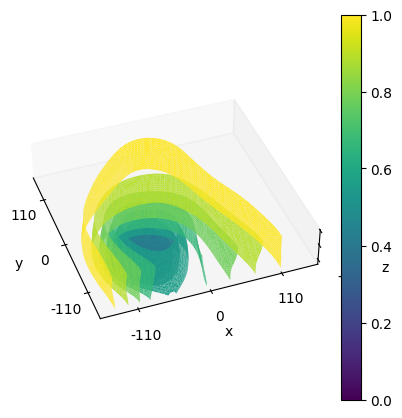

In [ ]:
from matplotlib.figure import projections
from numpy import sin, cos, pi
from skimage import measure
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, PolyCollection
import matplotlib.tri as mtri
   

vol = y_save[0,...,0]
print(vol.shape)

fig,ax = plt.subplots(1,1,figsize=(5, 5),subplot_kw=dict(projection='3d'))
# ax = fig.add_subplot(111, projection='3d')

h = np.linspace(-0.2, -0.01, 8)
h = np.arange(-0.2, -0.01, 0.02)

print(h)
facecolors = plt.colormaps['viridis'](np.linspace(0, 1, h.shape[0]))

for i in range(h.shape[0]):

  verts0, faces, normals, values = measure.marching_cubes(vol, h[i], spacing=(1/64, 1/64, 1/16))
  mesh = Poly3DCollection(verts0[faces], facecolors=facecolors[i])
  im = ax.add_collection3d(mesh)
  print(np.min(verts0))

ax.set_box_aspect((1.,1.,0.2))

xyticklabels = np.arange(50, 271, 110)-160
xyticks = (xyticklabels+160)/320

zticklabels = np.arange(-14,2,7)
zticks = -zticklabels/16
ax.set(xlim=(0.0, 1), ylim=(0.0, 1), zlim=(0,1),
       xticks=xyticks,yticks=xyticks,zticks=zticks,
       xticklabels=xyticklabels, yticklabels=xyticklabels,zticklabels=zticklabels,
       xlabel='y', ylabel='x', zlabel='z')

# Set zoom and angle view
ax.view_init(elev=220., azim=20)
ax.grid(False)

# for ii in np.arange(0,360,20):
#   ax.view_init(elev=ii, azim=40,roll=0)
#   fig.savefig(work_dir + "move/movie_40_%d.png" % ii)

plt.colorbar(im,ax=ax)
plt.show()

## Define NN Model

Input: Heads (normalized)

Output: Latent variables (alpha)


In [ ]:
# hidden_act = None
hidden_dim = 3000
hidden_normal = LayerNormalization(axis=1) # BatchNormalization()
input = Input(shape = (Y_train.shape[-1],))
# input = Input(shape = (600,))

g = BatchNormalization()(input)

# g = Dense(hidden_dim)(g)
# g = LayerNormalization(axis=1)(g)
# g = LeakyReLU(alpha=0.2)(g)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g_out = Dense(50)(g)
g_out = LayerNormalization(axis=1)(g_out)

G = Model(input, g_out, name = field_type+'_'+pumping_type)
G.summary()


# eigen_values = np.loadtxt('./Data/'+field_type+'_eigen_256.csv',dtype=np.float64)
alpha_loss_weight = np.ones((50,))
# alpha_loss_weight= eigen_values[0:50]

# alpha_loss_weight /= np.linalg.norm(alpha_loss_weight)


def weighted_mse(weights=alpha_loss_weight):
  def loss(y_true, y_pred):
    squared_difference_1 = tf.square(y_true - y_pred)*weights
    total_loss = tf.reduce_mean(squared_difference_1, axis=-1)
    return total_loss
  return loss

step = tf.Variable(0, trainable=False)
boundaries = [10000, 20000]
values = [1e-3, 1e-4, 1e-5]
learning_rate_fn = PiecewiseConstantDecay(
    boundaries, values)

# Later, whenever we perform an optimization step, we pass in the step.
learning_rate = learning_rate_fn(step)

# learning_rate = 0.0005
print(learning_rate)
G.compile(loss=weighted_mse(), optimizer=Adam(learning_rate, beta_1=0.5))

Model: "Gaussian_steady_state"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 600)]             0         
                                                                 
 batch_normalization_5 (Batc  (None, 600)              2400      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 3000)              1803000   
                                                                 
 batch_normalization_6 (Batc  (None, 3000)             12000     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 3000)              0         
                                                                 
 dense_6 (Dense)             (None, 3000)    

## Train Model

In [ ]:
import time
batch_size = 1000

epochs = 50000
print_interval = 1
start_time = time.time()
for epoch in range(epochs):
  idx = np.random.randint(0, Y_train.shape[0], batch_size)
  to_train = Y_train[idx,:600]
  expect_output = X_train[idx]

  loss = G.train_on_batch(to_train, expect_output)
  if epoch % print_interval == 0:
    colapsed_time = time.time()
    print("[epoch %d], [the loss is %f], [the time is %f]" % (epoch, loss, colapsed_time-start_time))
  start_time = time.time()
  if loss < 1e-5:
    break


[epoch 0], [the loss is 2.031979], [the time is 3.863912]
[epoch 1], [the loss is 1.222175], [the time is 0.097932]
[epoch 2], [the loss is 1.140102], [the time is 0.087167]
[epoch 3], [the loss is 1.072312], [the time is 0.069913]
[epoch 4], [the loss is 0.989275], [the time is 0.069831]
[epoch 5], [the loss is 0.929595], [the time is 0.066502]
[epoch 6], [the loss is 0.944924], [the time is 0.065921]
[epoch 7], [the loss is 0.927366], [the time is 0.066523]
[epoch 8], [the loss is 0.874619], [the time is 0.063770]
[epoch 9], [the loss is 0.850505], [the time is 0.062866]
[epoch 10], [the loss is 0.875304], [the time is 0.064133]
[epoch 11], [the loss is 0.804986], [the time is 0.065500]
[epoch 12], [the loss is 0.838890], [the time is 0.065118]
[epoch 13], [the loss is 0.809001], [the time is 0.065087]
[epoch 14], [the loss is 0.831503], [the time is 0.063363]
[epoch 15], [the loss is 0.776787], [the time is 0.063415]
[epoch 16], [the loss is 0.811828], [the time is 0.064806]
[epoch 

KeyboardInterrupt: ignored

## Load saved model

In [ ]:
# '_5000_normalized':0.377
# '_5000_512_normalized':0.99
# '_5000_512':0.87
# '_5000':0.36
# steady_state: 0.37
model_name = './head_to_latent_model/'+field_type+'_'+pumping_type+'_3D'
# G = load_model(model_name)
G = load_model(model_name, custom_objects={ 'loss': weighted_mse(alpha_loss_weight) })
# G.summary()

## Inverse on test data set

In [ ]:
predictions = G.predict(Y_test,verbose=0)

print(predictions.shape)

pred_imgs = np.matmul(predictions,Z).reshape((500, nx[0], nx[1], nx[2]), order='F')
true_imgs = np.matmul(X_test,Z).reshape((500, nx[0], nx[1], nx[2]), order='F')


16/16 [==============================] - 5s 4ms/step
(500, 50)


In [ ]:
print(predictions.shape)
print(type(predictions[0,0]))

print(Y_test.shape)

(500, 50)
<class 'numpy.float32'>
(500, 9600)


In [ ]:
data_dict = {
    'preds':predictions.astype(np.float64),
    'Y_test':Y_test.astype(np.float64),
    'Z': Z, 'rv':alpha
             }
import scipy
scipy.io.savemat("Gaussian_steady_state_monitored_0429_predictions.mat", data_dict)

In [ ]:
# np.savetxt('./Data/0719/'+field_type+'_'+pumping_type+'_preds_0719_512.csv', predictions)

# np.savetxt('./Data/0719/'+field_type+'_'+pumping_type+'_Z_0719_512.csv', Z)




In [ ]:
acc_list = np.zeros((1,Y_test.shape[0]))
thres = 0.15

for check_id in range(Y_test.shape[0]):

  logK_pred = pred_imgs[check_id,...]
  logK_true = true_imgs[check_id,...]
  K_len = np.max(logK_true) - np.min(logK_true)

  res = abs(logK_true-logK_pred)/K_len
  acc = np.sum(res<thres)/(ntot)

  acc_list[0,check_id] = acc

print("Min Acc: ", np.min(acc_list))
print("Max Acc: ", np.max(acc_list))
print("Arg Max Acc: ", np.argmax(acc_list))
print("Over 90%: ", acc_list[acc_list>=0.9].shape[0])

print("mean Acc: ", np.mean(acc_list))
print("std Acc: ", np.std(acc_list))
top5_est_list = np.argsort(acc_list)[0,-5:]
print(top5_est_list)


Min Acc:  0.8190460205078125
Max Acc:  1.0
Arg Max Acc:  7
Over 90%:  487
mean Acc:  0.9791775817871093
std Acc:  0.02679091080674423
[130 128 277  41 136]


In [ ]:
# head_data = mat73.loadmat('./Data/0719/'+field_type+'_'+pumping_type+'_pred_heads_0719_512.mat')

# pred_heads = head_data['pred_y']
# ref_heads = head_data['ref_y']

# err_list = np.zeros((1,Y_test.shape[0]))
# for check_id in range(Y_test.shape[0]):

#   ##### relative residual of head #####
#   head_pred = pred_heads[check_id,...].flatten()
#   head_true = Y_test[check_id].flatten()
#   err_list[0,check_id] = np.linalg.norm(head_pred-head_true,2)/np.linalg.norm(head_true,2)

# print("Min err: ", np.min(err_list))
# print("Max err: ", np.max(err_list))
# print("Arg Max err: ", np.argmax(err_list))

# print("mean err: ", np.mean(err_list))
# print("std err: ", np.std(err_list))

In [ ]:
# top5_est_list = np.argsort(acc_list[acc_list<1.0])[-10:]
top5_est_list = np.argsort(acc_list)[0,-10:]

print(top5_est_list)

bot5_est_list = np.argsort(acc_list)[0,0:10]
print(bot5_est_list)

top_alpha_mean = np.mean(X_test[top5_est_list],axis=1)
top_alpha_std = np.std(X_test[top5_est_list],axis=1)
print(top_alpha_mean.mean())
print(top_alpha_std.mean())

bot_alpha_mean = np.mean(X_test[bot5_est_list],axis=1)
bot_alpha_std = np.std(X_test[bot5_est_list],axis=1)
print(bot_alpha_mean.mean())
print(bot_alpha_std.mean())

[251 424 257 421  45 130 128 277  41 136]
[126 346  50 124 133 116 190  22   0 383]
-0.02129634491746662
0.9976051200407176
0.05400597352559503
0.8396895961684863


## Best Estimate

In [ ]:
# check_id = np.argmax(acc_list)
fid = np.argmax(acc_list)

print(fid)
logK_true = true_imgs[fid,:]
logK_pred = pred_imgs[fid,:]

fig= go.Figure(data=go.Isosurface(
    x=Xm.flatten(),
    y=Ym.flatten(),
    z=Zm.flatten(),
    value=logK_true.flatten(),
    # isomin=np.min(densityRealField),
    # isomax=np.max(densityRealField),
    surface_fill=0.4,
    caps=dict(x_show=False, y_show=False, z_show=False),

    slices_x=dict(show=True, locations=[0-Lx[0]*0.25, 0+Lx[0]*0.25]),
    slices_y=dict(show=True, locations=[0-Lx[1]*0.25, 0+Lx[1]*0.25]),
    slices_z=dict(show=True, locations=[0-Lx[2]*0.25, 0-Lx[2]*0.75]),
    colorscale='Jet'
))
fig.show()

fig= go.Figure(data=go.Isosurface(
    x=Xm.flatten(),
    y=Ym.flatten(),
    z=Zm.flatten(),
    value=logK_pred.flatten(),
    # isomin=np.min(densityRealField),
    # isomax=np.max(densityRealField),
    surface_fill=0.4,
    caps=dict(x_show=False, y_show=False, z_show=False),

    slices_x=dict(show=True, locations=[0-Lx[0]*0.25, 0+Lx[0]*0.25]),
    slices_y=dict(show=True, locations=[0-Lx[1]*0.25, 0+Lx[1]*0.25]),
    slices_z=dict(show=True, locations=[0-Lx[2]*0.25, 0-Lx[2]*0.75]),
    colorscale='Jet'
))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# check_id = np.argmax(acc_list)
fid = np.argmax(acc_list)
fid = 30
print(fid)
#set font size
axis_label_font_size = 28
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 30
title_size = 30

logK_true = true_imgs[fid,:]
logK_pred = pred_imgs[fid,:]

maxlK, minlK = np.max(logK_true), np.min(logK_true)

fig, axs = plt.subplots(1,2,figsize=(12,5))
ax = axs[0]
im = ax.pcolormesh(Xm,Ym,logK_true, cmap='jet')
im.set_clim((minlK, maxlK))
ax.set_title('(A). '+field_type+' Field',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

ax = axs[1]
im = ax.pcolormesh(Xm,Ym,logK_pred, cmap='jet')
# im.set_clim((minlK, maxlK))

ax.set_title('(B). Estimation',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
# ax.set_ylabel('y',fontsize=axis_label_font_size)

cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

# threshold 10%
thres = 0.10
K_len = maxlK - minlK 

res = abs(logK_true-logK_pred)/K_len

acc = np.sum(res<thres)/(ntot)

# fig.savefig(fig_path+field_type+'_'+pumping_type+'_best.png',bbox_inches="tight")


In [ ]:
# check_id = fid
# fig, axs = plt.subplots(1,2,figsize=(10,5))

# ax = axs[0]
# plot_max = max(np.max(predictions[check_id]), np.max(X_test[check_id,:]))
# plot_min = min(np.min(predictions[check_id]), np.min(X_test[check_id,:]))

# ax.plot(predictions[check_id,:15],X_test[check_id,:15],'ob')
# ax.plot(predictions[check_id,15:],X_test[check_id,15:],'ob')
# ax.plot(np.linspace(plot_min,plot_max,5),np.linspace(plot_min,plot_max,5),'-r')

# ax.set_xlabel('Pred')
# ax.set_ylabel('True')

# ax = axs[1]
# xplot = np.arange(predictions.shape[1])
# ax.plot(xplot, X_test[check_id,:],'or',label='true')
# ax.plot(xplot, predictions[check_id,:],'b',label='est')

# ax.legend()

In [ ]:
#set font size
from mpl_toolkits.axes_grid1 import make_axes_locatable

# check_id = np.argmax(acc_list)
fid = np.argmax(acc_list)
fid=214
print(fid)
#set font size
axis_label_font_size = 28
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 30
title_size = 30
logK_true = true_imgs[fid,:].reshape((nx,ny), order='F')
logK_pred = pred_imgs[fid,:].reshape((nx,ny), order='F')

maxlK, minlK = np.max(logK_true), np.min(logK_true)

fig, axs = plt.subplots(2,3,figsize=(23,13), gridspec_kw={'width_ratios': [1, 1, 1]})
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.55, 
                    hspace=0.4)

axs = axs.flatten()
ax = axs[0]
im = ax.pcolormesh(Xm,Ym,logK_true, cmap='jet')
im.set_clim((minlK, maxlK))
ax.set_title('(A). Reference ln$T$',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.15)
cbar = fig.colorbar(im, cax=cax)

# cbar = fig.colorbar(im, ax=ax, fraction=0.0000006, shrink=1.0)
cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

X_star = np.hstack((Xm.flatten()[:,None], Ym.flatten()[:,None]))

pump_id_list = np.arange(1,25)
# shift = 40
shift = -40-512*10
for i in range(25):
  texts = 'p'+str(i+1)
  ax.text(X_star[pump_cell_idx[i]+shift,0], X_star[pump_cell_idx[i]+shift,1], texts, c='k', fontsize=15, ha='left', va='top')
ax.scatter(X_star[pump_cell_idx,0], X_star[pump_cell_idx,1], marker="o", zorder=1, alpha= 1, c='k', s=50, label="pump")
# ax.scatter(X_star[pump_cell_idx[pump_id_list],0], X_star[pump_cell_idx[pump_id_list],1], marker="o", zorder=1, alpha= 1, c='r', s=40, label="pump")



######################################
######################################
######################################
ax = axs[1]
im = ax.pcolormesh(Xm,Ym,logK_pred, cmap='jet')
# im.set_clim((minlK, maxlK))

ax.set_title('(B). Estimated ln$T$',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

# cbar = fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.15)
cbar = fig.colorbar(im, cax=cax)

# cbar = fig.colorbar(im, ax=ax, fraction=0.0000006, shrink=1.0)
cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')



######################################
######################################
######################################
# fig,ax = plt.subplots(figsize=(5.6,5.6))
# #set font size
# axis_label_font_size = 28
# axis_tick_font_size = 30
# legend_fontszie = 25
# colorbar_font_size = 30
# title_size = 28

######### compute r2 score of the regression: logK = inv_logK #########
logK_true_plot = logK_true.flatten()
logK_pred_plot = logK_pred.flatten()
var_model = np.sum((logK_pred_plot - logK_true_plot)**2)
var_data = np.sum((logK_true_plot-np.mean(logK_true_plot))**2)
r2_inverse_logK = (var_data-var_model) / var_data
print(r2_inverse_logK)

######### plot logK scatter: true vs. estimation #########

ax = axs[3]
min_logK_true_plot, max_logK_true_plot = min(logK_true_plot), max(logK_true_plot)
min_logK_pred_plot, max_logK_pred_plot = min(logK_pred_plot), max(logK_pred_plot)

ax.scatter(logK_pred_plot,logK_true_plot, label='logK',color='r')
scaler = 1.5
ax.plot([min_logK_true_plot*scaler, max_logK_true_plot*scaler], [min_logK_true_plot*scaler, max_logK_true_plot*scaler],color='k')
# ax.plot([-1.3, 1.2], [-1.3, 1.2],color='k')

# ticks = [min_logK_true_plot, 0.0, max_logK_true_plot]
# labels = [min_logK_true_plot, 0.0, max_logK_true_plot]

ticks = [-1.5, 0.0, 1.5]
labels = [-1.5, 0.0, 1.5]

######### x-axis name, ticks and labels #########
ax.set_xlabel('Estimated ln$T$',fontsize=axis_label_font_size)
ax.set_xticks(ticks)
ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
ax.set_xlim([-1.8, 1.8])
######### x-axis name, ticks and labels #########
ax.set_ylabel('True ln$T$',fontsize=axis_label_font_size)
ax.set_yticks(ticks)
ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')
ax.set_ylim([-1.8, 1.8])

# ######### figure title #########
# ax.set_title('(F). $lnT$ data vs. pred',fontsize=title_size)

######### xfigure text #########
ax.text(-1.5, 1.2, '$R^2$=%.4f'%(r2_inverse_logK), fontsize=30,
        bbox={'edgecolor':'w','facecolor':'w'})

ax.set_title('(C). True vs. Estimation', fontsize=title_size)




######################################
######################################
######################################
ax = axs[4]
xplot = np.arange(1, predictions.shape[1]+1)
ax.plot(xplot, X_test[fid,:],'or',label='true')
ax.plot(xplot, predictions[fid,:],'b',label='est')


xticks = [1, 10, 20, 30, 40, 50] #np.arange(1, predictions.shape[1]+1,9)
xlabels = [1, 10, 20, 30, 40, 50] #np.arange(1, predictions.shape[1]+1,9)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels,Fontsize=axis_tick_font_size,ha='center')

yticks = np.arange(-2, 3)
ylabels = np.arange(-2, 3)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels,Fontsize=axis_tick_font_size, ha='right', va='center')

ax.set_ylim([np.floor(min(np.hstack((X_test[fid,:],predictions[fid,:]))))-0.3,
             np.ceil(max(np.hstack((X_test[fid,:],predictions[fid,:]))))+0.3])

ax.set_xlabel('Index',fontsize=axis_label_font_size)
ax.set_ylabel('Value',fontsize=axis_label_font_size)

ax.legend(loc='upper left',ncol=1,prop={'size': legend_fontszie}, framealpha=1, \
          facecolor='none',borderpad=0.2,labelspacing=0.1,handletextpad=0.5, handlelength=0.2,columnspacing=0.02)

ax.set_title('(D). Latent variables',fontsize=title_size)



######### compute r2 score of the regression: head = inv_head #########
head_true_plot = Y_test[fid,...].flatten()
head_pred_plot = pred_heads[fid,...].flatten()
var_model = np.sum((head_pred_plot - head_true_plot)**2)
var_data = np.sum((head_true_plot-np.mean(head_true_plot))**2)
r2_inverse_head = (var_data-var_model) / var_data
print(r2_inverse_head)


######### plot head scatter: true vs. estimation #########

ax = axs[5]
min_head_true_plot, max_head_true_plot = min(head_true_plot), max(head_true_plot)
min_head_pred_plot, max_head_pred_plot = min(head_pred_plot), max(head_pred_plot)
print(min_head_true_plot, max_head_true_plot)
print(min_head_pred_plot, max_head_pred_plot)
ax.scatter(head_pred_plot,head_true_plot, label='head',color='g')
ax.plot([min_head_true_plot*scaler, max_head_true_plot*0], [min_head_true_plot*scaler, max_head_true_plot*0],color='k')
# ax.plot([-1.3, 1.2], [-1.3, 1.2],color='k')

# ticks = [min_head_true_plot, 0.0, max_head_true_plot]
# labels = [min_head_true_plot, 0.0, max_head_true_plot]

ticks = [-3.0,-1.5,-0.2]
labels = [-3.0,-1.5,-0.2]

######### x-axis name, ticks and labels #########
ax.set_xlabel('Simulated head [m]',fontsize=axis_label_font_size)
ax.set_xticks(ticks)
ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
ax.set_xlim([-3.1,-0.1])
######### x-axis name, ticks and labels #########
ax.set_ylabel('Input head [m]',fontsize=axis_label_font_size)
ax.set_yticks(ticks)
ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')
ax.set_ylim([-3.1,-0.1])

# ######### figure title #########
# ax.set_title('(F). $lnT$ data vs. pred',fontsize=title_size)

######### xfigure text #########
ax.text(-2.8,-0.6, '$R^2$=%.4f'%(r2_inverse_head), fontsize=30,
        bbox={'edgecolor':'w','facecolor':'w'})

ax.set_title('(E). Hydraulic heads', fontsize=title_size)


axs[2].axis('off')

# threshold 10%
thres = 0.15
K_len = maxlK - minlK 

acc = abs(logK_true-logK_pred)/K_len

print(sum(sum(acc<thres))/(nx*ny))

fig.savefig(fig_path+field_type+'_'+pumping_type+'5plots_best.png',bbox_inches="tight")


## Wrost Estimate

In [ ]:
# check_id = np.argmax(acc_list)
fid = np.argmin(acc_list)

#set font size
axis_label_font_size = 28
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 30
title_size = 30

logK_true = true_imgs[fid,:].reshape((nx,ny), order='F')
logK_pred = pred_imgs[fid,:].reshape((nx,ny), order='F')

maxlK, minlK = np.max(logK_true), np.min(logK_true)

fig, axs = plt.subplots(1,2,figsize=(12,5))
ax = axs[0]
im = ax.pcolormesh(Xm,Ym,logK_true, cmap='jet')
im.set_clim((minlK, maxlK))
ax.set_title('(A). '+field_type+' Field',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

ax = axs[1]
im = ax.pcolormesh(Xm,Ym,logK_pred, cmap='jet')
# im.set_clim((minlK, maxlK))

ax.set_title('(B). Estimation',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
# ax.set_ylabel('y',fontsize=axis_label_font_size)

cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

# threshold 10%
thres = 0.15
K_len = maxlK - minlK 

acc = abs(logK_true-logK_pred)/K_len

print(sum(sum(acc<thres))/(nx*ny))

fig.savefig(fig_path+field_type+'_'+pumping_type+'_wrost.png',bbox_inches="tight")


In [ ]:
check_id = fid
fig, axs = plt.subplots(1,2,figsize=(10,5))

ax = axs[0]
plot_max = max(np.max(predictions[check_id]), np.max(X_test[check_id,:]))
plot_min = min(np.min(predictions[check_id]), np.min(X_test[check_id,:]))

ax.plot(predictions[check_id,:15],X_test[check_id,:15],'ob')
ax.plot(predictions[check_id,15:],X_test[check_id,15:],'ob')
ax.plot(np.linspace(plot_min,plot_max,5),np.linspace(plot_min,plot_max,5),'-r')

ax.set_xlabel('Pred')
ax.set_ylabel('True')

ax = axs[1]
xplot = np.arange(predictions.shape[1])
ax.plot(xplot, X_test[check_id,:],'or',label='true')
ax.plot(xplot, predictions[check_id,:],'b',label='est')

ax.legend()

## Uncertainty Quantification

In [ ]:
fid = np.argmax(acc_list)
n_noises = 20
# print(Y_test.shape)
# print(Y_test[fid].shape)
Noised_Y_test = Y_test[fid] + np.random.normal(0,np.abs(Y_test[fid]*0.05),[n_noises,Y_test[fid].shape[0]])
# print(Y_test[fid,0:5])

# print(Noised_Y_test[0:2,0:5])
predictions = G.predict(Noised_Y_test)

# print(predictions.shape)

pred_imgs = np.matmul(predictions,Z)
true_imgs = np.matmul(X_test[fid],Z)

acc_list = np.zeros((n_noises,))
thres = 0.15
logK_true = true_imgs.reshape((nx,ny), order='F')

for check_id in range(n_noises):

  logK_pred = pred_imgs[check_id,:].reshape((nx,ny), order='F')
  K_len = np.max(logK_true) - np.min(logK_true)

  res = abs(logK_true-logK_pred)/K_len
  acc = sum(sum(res<thres))/(nx*ny)

  acc_list[check_id] = acc

print("Min Acc: ", np.min(acc_list))
print("Max Acc: ", np.max(acc_list))
print("Arg Max Acc: ", np.argmax(acc_list))
print("Over 90%: ", acc_list[acc_list>=0.9].shape[0])

print("mean Acc: ", np.mean(acc_list))
print("std Acc: ", np.std(acc_list))



In [ ]:
#set font size
from mpl_toolkits.axes_grid1 import make_axes_locatable

axis_label_font_size = 20
axis_tick_font_size = 20
legend_fontszie = 20
colorbar_font_size = 20
title_size = 20

plot_id_list = np.argsort(acc_list)[-10:]

print(plot_id_list)
fig, axs = plt.subplots(2, 5, figsize=(30,10)) 

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

axs = axs.flatten()
logK_true = true_imgs.reshape((nx,ny), order='F')

for i in range(axs.shape[0]):
  ax = axs[i]
  logK_pred = pred_imgs[plot_id_list[i],:].reshape((nx,ny), order='F')

  if i == 0:
    im = ax.pcolormesh(Xm,Ym,logK_true, cmap='jet')
    ax.set_title('True '+field_type+' Field',fontsize=title_size)

  else:
    im = ax.pcolormesh(Xm,Ym,logK_true, cmap='jet')
    acc = acc_list[plot_id_list[i]]*100
    ax_name = "Acc = %.2f %%" % acc
    ax.set_title(ax_name, fontsize=title_size)

  im.set_clim((minlK, maxlK))

  ax.set_xlabel('x',fontsize=axis_label_font_size)
  ax.set_ylabel('y',fontsize=axis_label_font_size)
    
  # create an axes on the right side of ax. The width of cax will be 5%
  # of ax and the padding between cax and ax will be fixed at 0.05 inch.
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="10%", pad=0.15)
  cbar = fig.colorbar(im, cax=cax)

  # cbar = fig.colorbar(im, ax=ax, fraction=0.0000006, shrink=1.0)
  cbar.ax.tick_params(labelsize=colorbar_font_size)


  ticks = [-0.4, 0.0, 0.4]

  labels = [0.1, 0.5, 0.9]
  ax.set_xticks(ticks)
  ax.set_yticks(ticks)
  ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
  ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

  fig.savefig(fig_path+field_type+'_'+pumping_type+'_noises.png',bbox_inches="tight")


In [ ]:
# r, c = 2, 3
# fig, axs = plt.subplots(r, c, figsize=(10,5),constrained_layout=True) 
# for i in range(c):
#   logK_pred = pred_imgs[fid+i,:].reshape((nx,ny), order='F')
#   logK_true = true_imgs[fid+i,:].reshape((nx,ny), order='F')
#   # threshold 10%
#   thres = 0.1
#   K_len = np.max(logK_true) - np.min(logK_true)

#   ax = axs.flatten()[i]
#   im = ax.pcolormesh(Xm, Ym, logK_true, cmap='jet', vmin = -5, vmax = 5)
#   ######### colorbar ticks and labels #########
#   cbar = fig.colorbar(im, ax=ax)
#   # access to cbar tick labels:
#   # cbar.ax.tick_params(labelsize=colorbar_font_size) 

#   ax2 = axs.flatten()[i+3]
#   im = ax2.pcolormesh(Xm, Ym, logK_pred, cmap='jet', vmin = -5, vmax = 5)
#   ######### colorbar ticks and labels #########
#   cbar = fig.colorbar(im, ax=ax2)
#   # access to cbar tick labels:
#   # cbar.ax.tick_params(labelsize=colorbar_font_size) 


In [ ]:
# r, c = 1, 3
# fig = plt.fig, axs = plt.subplots(r, c, figsize=(10,3),constrained_layout=True) 

# for i in range(3):
#   logK_pred = pred_imgs[fid+i,:].reshape((nx,ny), order='F')
#   logK_true = true_imgs[fid+i,:].reshape((nx,ny), order='F')
#   # threshold 10%
#   thres = 0.1
#   K_len = np.max(logK_true) - np.min(logK_true)
#   diff = abs(logK_true-logK_pred)
#   T = K_len * thres

#   count = np.sum(np.sum(diff <= T))
#   acc = count/(128*128)
    
#   ax = axs[i]
#   ax.hist(diff, bins = 40, label = "MA Threshold: {:.2f}".format(T))
#   # ax.xlim(0)
#   ax.axvline(x = T, c = 'r', label = "MA: {:.2%}".format(acc))
#   ax.legend(("MA Threshold: {:.2f}".format(T), "MA: {:.2%}".format(acc)))




In [ ]:
# def makeColours( vals ):
#     colours = np.zeros( (len(vals),3) )
#     norm = Normalize( vmin=vals.min(), vmax=vals.max() )

#     #Can put any colormap you like here.
#     colours = [cm.ScalarMappable( norm=norm, cmap='jet').to_rgba( val ) for val in vals]
#     return colours

# logK_pred = pred_imgs[fid+i,:].reshape((nx,ny), order='F')
# logK_true = true_imgs[fid+i,:].reshape((nx,ny), order='F')

# plot_max = max(np.max(logK_pred), np.max(logK_true))
# plot_min = min(np.min(logK_pred), np.min(logK_true))


# samples = [pred_imgs[fid+i,:], true_imgs[fid+i,:]]
# densObj = kde(samples)
# colours = makeColours( densObj.evaluate( samples ) )
# corr = np.corrcoef(x, y)[0,1]
# print(corr)

# r, c = 1, 1
# fig, ax = plt.subplots(r, c, figsize=(5,5),constrained_layout=True) 
# # ax = axs[0]
# ax.scatter( samples[0], samples[1], color=colours, s=70, alpha=0.03 )
# ax.plot(np.linspace(plot_min,plot_max,5),np.linspace(plot_min,plot_max,5),'-r', label = "Correlation = {:.3f}".format(corr))
# ax.legend(handlelength=0)
# ax.set_xlim(plot_min, plot_max)
# ax.set_ylim(plot_min, plot_max)
# ax.set_xlabel("Pred")
# ax.set_ylabel("True")

## Save Model
Directory: head_to_latent_model

field_type: Gaussian or Exponential

pumping type: steady_state or transient

In [ ]:
G.save('./head_to_latent_model/'+field_type+'_'+pumping_type+'_3D')